In [1]:
from IPython.display import display

from sympy.interactive import printing
printing.init_printing(use_latex=True)

from __future__ import division
import sympy as sym
from sympy import *

%matplotlib inline
from matplotlib import rc
import matplotlib.pyplot as plt
rc('font',**{'family':'serif','size'   : 12})

In [2]:
from qutip import *

# Several constants

In [3]:
from __future__ import division, print_function, unicode_literals

# Basic constants
pi = 3.1415926
c = 299792458
h = 6.62606957e-34
hbar = h / 2 / pi
k_B = 1.3806488e-23
m_e = 9.10938291e-31
m_p = 1.672621898e-27
mu_0 = 4e-7 * pi
epsilon_0 = 1 / c**2 / mu_0
E = 1.602176565e-19
N_A = 6.02214129e+23


# Mass of Sr-88, Sr-87, Sr-86, Sr-84
M88 = 1.459706905272492E-25  
M87 = 1.4431557366419E-25  
M86 = 1.42655671117996E-25
M84 = 1.3934150821E-25
M = M88

In [4]:
Nx = 15   # Dimension of x-harmonic oscillator
m = 10
omega_x = 2* pi * 200   # In units of kHz
delta = -2 * pi * 200   # In units of kHz
omega = 2 * pi * 50    # In units of kHz
gamma = 2 * pi * 7      # In units of kHz
eta = 0.2
g = basis(2,0)          # Ground state
e = basis(2,1)          # Excited state
x = fock(Nx, m)        # x-harmonic oscillator

# Destruction operators in 1d
a_x = destroy(Nx)

# H_eff / hbar, otherwise too small, too many floats
H = tensor(omega_x * (a_x.dag() * a_x + 0.5), qeye(2)) - tensor(qeye(Nx), 0.5 * delta * sigmaz()) + omega * 0.5 * (tensor((1j * eta * (a_x + a_x.dag())).expm(), sigmap()) + tensor((-1j * eta * (a_x + a_x.dag())).expm(), sigmam()))

# Wavefunction in 1d, start from all in ground state
psi0 = tensor(x, g)

[ 0.69] [ 1.]
[ 0.84  0.17  0.6   0.75  0.67] [ 0.50709876  0.32244867  0.44095544  0.48229501  0.46024724]
[ 0.93  0.84  0.8   0.47 -0.07  0.6   0.45  0.33  0.01  0.46] [ 0.40278848  0.3840056   0.37565765  0.30678708  0.19408979  0.33391791
  0.30261311  0.27756926  0.21078568  0.30470009]
[ 0.57  0.08 -0.03 -0.38 -0.35  0.91  0.13  0.78  0.17  0.93  0.32  0.23
  0.51  0.98  0.87  0.88 -0.24 -0.06  0.39  0.86] [ 0.24252694  0.16683382  0.14984149  0.09577497  0.10040924  0.2950487
  0.17455761  0.27496685  0.18073664  0.29813822  0.203908    0.19000519
  0.2332584   0.30586201  0.28886967  0.29041443  0.11740158  0.14520721
  0.21472131  0.28732491]


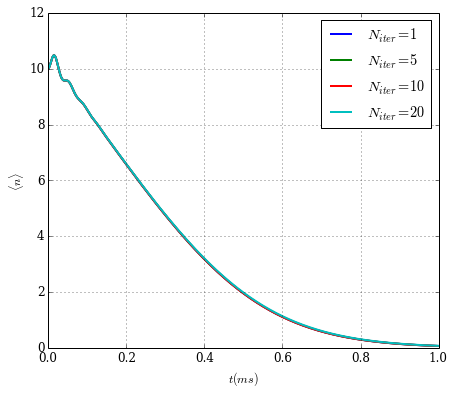

In [5]:
# Now we combine the two, we solve for each u exactly, but we generate u from the dipole distribution

from numpy import linspace, arange, divide, sqrt
from scipy import stats

# Randomly generate u from dipole distribution
du = 0.01
u_ = arange(-1, 1, du)
p = [3 / 8 * (1 + u__) ** 2 for u__ in u_]
p = divide(p, sum(p))
dipole = stats.rv_discrete(name = 'custm', values = (range(len(p)), p))

dt = 1    # Time length
times = linspace(0.0, dt, 1000)
N_iter = [1, 5, 10, 20]
# N_iter = [1, 5]

import matplotlib.gridspec as gridspec
figure = plt.figure(figsize=(7, 6))
gs = gridspec.GridSpec(1, 1)
gs.update(wspace=0.3,hspace=0.4)
ax1 = plt.subplot(gs[0,0]) 

for N_iter_ in N_iter:
    idx = dipole.rvs(size = N_iter_)
    u = u_[idx]
    q = p[idx]
    q = divide(q, sum(q)) 
    q = sqrt(q)
    print(u, q)
    result = mesolve(H, psi0, times, [sqrt(gamma) * q[i] * tensor((1j * u[i] * eta * (a_x + a_x.dag())).expm(), sigmam()) for i in range(len(u))], [tensor(a_x.dag() * a_x, qeye(2))])
    ax1.plot(result.times, result.expect[0], label = '$N_{iter} = %d$' % (N_iter_), linewidth = 2, linestyle = '-');

ax1.set_xlabel("$t (ms)$")
ax1.set_ylabel(r"$\langle n \rangle$")
ax1.legend(loc = 1)
ax1.grid(1)

[ 0.81] [ 1.]
37.7378690243
[ 0.82  0.99  0.8   0.99  0.91] [ 0.42754704  0.46748275  0.42284872  0.46748275  0.44868947]
85.6319360733


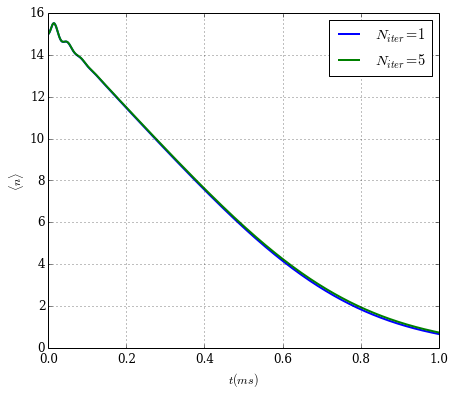

In [8]:
# Then I want to know how fast the algorithm can be
# From above it seems like up to 5 iterations is enough
# For Nx = 20 will take 37 s for 1 point and 90 s (5 points in total)
# For Nx = 30 will take 3 min for 1 point
# Then we estimate this is almost N^3 to N^4, for Nx = 50 will take 0.5 h for 1 point and for Nx = 100 will take 5 hs for 1 point
# Ideally this can be better for better computers

import timeit

Nx = 20   # Dimension of x-harmonic oscillator
m = 15
omega_x = 2* pi * 200   # In units of kHz
delta = -2 * pi * 200   # In units of kHz
omega = 2 * pi * 50    # In units of kHz
gamma = 2 * pi * 7      # In units of kHz
eta = 0.2
g = basis(2,0)          # Ground state
e = basis(2,1)          # Excited state
x = fock(Nx, m)        # x-harmonic oscillator

# Destruction operators in 1d
a_x = destroy(Nx)

# H_eff / hbar, otherwise too small, too many floats
H = tensor(omega_x * (a_x.dag() * a_x + 0.5), qeye(2)) - tensor(qeye(Nx), 0.5 * delta * sigmaz()) + omega * 0.5 * (tensor((1j * eta * (a_x + a_x.dag())).expm(), sigmap()) + tensor((-1j * eta * (a_x + a_x.dag())).expm(), sigmam()))

# Wavefunction in 1d, start from all in ground state
psi0 = tensor(x, g)

# Randomly generate u from dipole distribution
du = 0.01
u_ = arange(-1, 1, du)
p = [3 / 8 * (1 + u__) ** 2 for u__ in u_]
p = divide(p, sum(p))
dipole = stats.rv_discrete(name = 'custm', values = (range(len(p)), p))

dt = 1    # Time length
times = linspace(0.0, dt, 1000)
# N_iter = [1, 5, 10, 20]
N_iter = [1, 5]

import matplotlib.gridspec as gridspec
figure = plt.figure(figsize=(7, 6))
gs = gridspec.GridSpec(1, 1)
gs.update(wspace=0.3,hspace=0.4)
ax1 = plt.subplot(gs[0,0]) 
start = timeit.default_timer()

for N_iter_ in N_iter:
    idx = dipole.rvs(size = N_iter_)
    u = u_[idx]
    q = p[idx]
    q = divide(q, sum(q)) 
    q = sqrt(q)
    print(u, q)
    result = mesolve(H, psi0, times, [sqrt(gamma) * q[i] * tensor((1j * u[i] * eta * (a_x + a_x.dag())).expm(), sigmam()) for i in range(len(u))], [tensor(a_x.dag() * a_x, qeye(2))])
    ax1.plot(result.times, result.expect[0], label = '$N_{iter} = %d$' % (N_iter_), linewidth = 2, linestyle = '-');
    stop = timeit.default_timer()
    print(stop - start)     # Time spent in seconds
    
ax1.set_xlabel("$t (ms)$")
ax1.set_ylabel(r"$\langle n \rangle$")
ax1.legend(loc = 1)
ax1.grid(1)